In [2]:
# Pandas dataframe
import pandas as pd
from pandas import DataFrame

# Scikit-Learn
import sklearn 
from sklearn import datasets, linear_model, metrics, tree
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score

# Models
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import (BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, 
RandomForestRegressor, AdaBoostRegressor)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
        
import joblib
from matplotlib import pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [3]:
df_em = pd.read_csv("../hao/dataset_scaled_emission.csv")

In [4]:
#Checks the column names, and ensures that they do not have any leading or trailing spaces
df_em.columns = df_em.columns.str.strip()

In [5]:
# Input for ML models

input_col = ['in_amount_mmol',
             'p_amount_mmol',
             'sol_amount_ml',
             'TOP_amount_mmol',
             'acid_amount_mmol',
             'amine_amount_mmol',
             'thiol_amount_mmol',
             'zinc_amount_mmol',
             'other_amount_mmol',
             'total_volume_ml',
             'temp_c',
             'time_min',
             'x0_chloroindium oxalate',
             'x0_indium acetate',
             'x0_indium bromide',
             'x0_indium chloride',
             'x0_indium iodide',
             'x0_indium myristate',
             'x0_indium oxalate',
             'x0_indium palmitate',
             'x0_indium trifluoroacetate',
             'x0_indium tris(N,N-diisopropylacetamidinato)',
             'x1_bis(trimethylsilyl)phosphine',
             'x1_phosphine gas',
             'x1_phosphorus trichloride',
             'x1_sodium phosphide',
             'x1_tris(diethylamino)phosphine',
             'x1_tris(dimethylamino)phosphine',
             'x1_tris(trimethylgermyl)phosphine',
             'x1_tris(trimethylsilyl)phosphine',
             'x1_white phosphorus',
             'x2_4-ethylpyridine',
             'x2_None',
             'x2_dimethylformamide',
             'x2_mesitylene',
             'x2_octadecene',
             'x2_toluene',
             'x3_None',
             'x3_trioctylphosphine',
             'x4_None',
             'x4_lauric acid',
             'x4_myristic acid',
             'x4_oleic acid',
             'x4_palmitic acid',
             'x4_stearic acid',
             'x5_None',
             'x5_dioctylamine',
             'x5_dodecylamine',
             'x5_hexadecylamine',
             'x5_octylamine',
             'x5_oleylamine',
             'x6_None',
             'x6_dodecanethiol',
             'x7_None',
             'x7_zinc acetate',
             'x7_zinc bromide',
             'x7_zinc chloride',
             'x7_zinc iodide',
             'x7_zinc octanoate',
             'x7_zinc oleate',
             'x7_zinc stearate',
             'x7_zinc undecylenate',
             'x8_None',
             'x8_acetic acid',
             'x8_copper bromide',
             'x8_superhydride',
             'x8_oleic acid',
             'x8_tetrabutylammonium myristate',
             'x8_trioctylamine',
             'x8_trioctylphosphine oxide',
             'x8_water',
             'x8_zinc iodide'
            ]

output_col = ['emission_nm']

X = df_em[input_col]

Y = df_em[output_col]

In [6]:
# Splitting dataset for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=45, shuffle=True)

# Hyper parameter tuning
## Ensemble regressors

### Bagging

In [30]:
%%time

#sklearn random search over n iterations
#define ranges of paramaters to tune
#the internet tunes these parameters for bagging

params = {'n_estimators': range(10,1001)}

#n_jobs runs jobs in parallel, verbose prints updates in command line
rs_bag = RandomizedSearchCV(BaggingRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_bag.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_bag.best_score_)
print('Best Parameters : ',rs_bag.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -37.372
Best Parameters :  {'n_estimators': 78}
CPU times: user 2.94 s, sys: 210 ms, total: 3.15 s
Wall time: 4min 4s


Mean absolute error = 30.94 nm


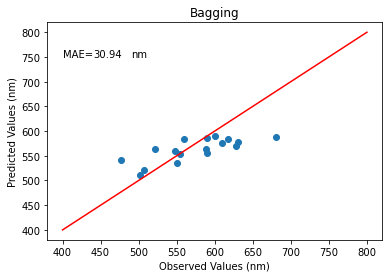

In [33]:
#using random search parameters
B_regr = BaggingRegressor(n_estimators=78)
B_regr.fit(X_train, np.ravel(Y_train))
            
B_Y_pred = B_regr.predict(X_test)
            
B_mae = mean_absolute_error(Y_test, B_Y_pred)
print("Mean absolute error =", round(B_mae,3), 'nm')

plt.figure()
plt.title("Bagging")
plt.plot(Y_test, B_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(B_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Random Forest

In [34]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_rf = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_rf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_rf.best_score_)
print('Best Parameters : ',rs_rf.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -37.681
Best Parameters :  {'n_estimators': 174}
CPU times: user 3.32 s, sys: 123 ms, total: 3.44 s
Wall time: 3min 39s


Mean absolute error = 29.89 nm


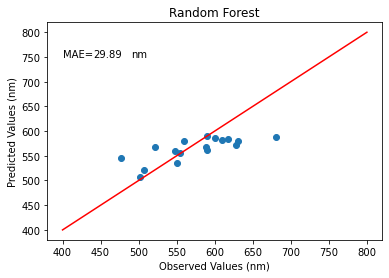

In [38]:
#using search parameters
RF_regr = RandomForestRegressor(n_estimators=174)
RF_regr.fit(X_train, np.ravel(Y_train))
            
RF_Y_pred = RF_regr.predict(X_test)
            
RF_mae = mean_absolute_error(Y_test, RF_Y_pred)
print("Mean absolute error =", round(RF_mae,3), 'nm')

plt.figure()
plt.title("Random Forest")
plt.plot(Y_test, RF_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(RF_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Decision Tree

In [39]:
%%time

#sklearn random search

params = {'min_samples_split': range(2,100),
          'min_samples_leaf':range(1,100)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_dt = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_dt.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_dt.best_score_)
print('Best Parameters : ',rs_dt.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -42.262
Best Parameters :  {'min_samples_split': 13, 'min_samples_leaf': 17}
CPU times: user 3.45 s, sys: 127 ms, total: 3.57 s
Wall time: 9.72 s


Mean absolute error = 32.753 nm


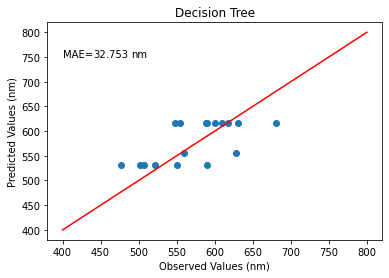

In [42]:
#using grid search parameters
DT_regr = DecisionTreeRegressor(min_samples_split=13, min_samples_leaf=17)
DT_regr.fit(X_train, np.ravel(Y_train))
            
DT_Y_pred = DT_regr.predict(X_test)
            
DT_mae = mean_absolute_error(Y_test, DT_Y_pred)
print("Mean absolute error =", round(DT_mae,3), 'nm')

plt.figure()
plt.title("Decision Tree")
plt.plot(Y_test, DT_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(DT_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Extra Trees

In [43]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,10),
         'min_samples_leaf': range(1,10)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_et = RandomizedSearchCV(ExtraTreesRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_et.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_et.best_score_)
print('Best Parameters : ',rs_et.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -39.726
Best Parameters :  {'n_estimators': 961, 'min_samples_split': 9, 'min_samples_leaf': 1}
CPU times: user 4.66 s, sys: 82.7 ms, total: 4.75 s
Wall time: 3min 19s


Mean absolute error = 43.191 nm


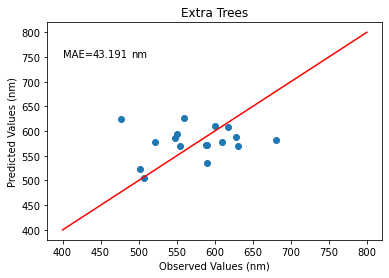

In [46]:
ET_regr = ExtraTreesRegressor(n_estimators=961, min_samples_split=9, min_samples_leaf=1)
            
ET_regr.fit(X_train, np.ravel(Y_train))
            
ET_Y_pred = ET_regr.predict(X_test)
            
ET_mae = mean_absolute_error(Y_test, ET_Y_pred)
print("Mean absolute error =", round(ET_mae,3), 'nm')

plt.figure()
plt.title("Extra Trees")
plt.plot(Y_test, ET_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(ET_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ada Boost

In [47]:
%%time

#sklearn random search

params = {'n_estimators': range(50,501),
          'learning_rate':range(1,11),
         'loss':['linear', 'square', 'exponential']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_ab = RandomizedSearchCV(AdaBoostRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_ab.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_ab.best_score_)
print('Best Parameters : ',rs_ab.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -35.983
Best Parameters :  {'n_estimators': 140, 'loss': 'exponential', 'learning_rate': 3}
CPU times: user 3.18 s, sys: 139 ms, total: 3.32 s
Wall time: 1min 23s


Mean absolute error = 31.927 nm


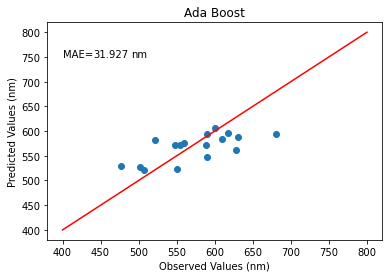

In [16]:
AB_regr = AdaBoostRegressor(n_estimators=140, loss='exponential', learning_rate=3)
            
AB_regr.fit(X_train, np.ravel(Y_train))
AB_Y_pred = AB_regr.predict(X_test)
            
AB_mae = mean_absolute_error(Y_test, AB_Y_pred)
print("Mean absolute error =", round(AB_mae,3), 'nm')

plt.figure()
plt.title("Ada Boost")
plt.plot(Y_test, AB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(AB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Gradient Boosting

In [17]:
%%time

#sklearn random search

params = {'n_estimators': range(100,1001),
          'min_samples_split':range(2,21),
         'min_samples_leaf': range(1,11),
         'max_depth':range(3,31)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_gb.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_gb.best_score_)
print('Best Parameters : ',rs_gb.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -35.073
Best Parameters :  {'n_estimators': 236, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_depth': 6}
CPU times: user 3.46 s, sys: 158 ms, total: 3.62 s
Wall time: 1min 10s


In [38]:
%%time

#sklearn random search

params = {'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_gb = RandomizedSearchCV(GradientBoostingRegressor(n_estimators=236, min_samples_split=19, min_samples_leaf=5, max_depth=6), param_distributions=params, n_iter=200, n_jobs=-1, verbose=10,
                          scoring='neg_mean_absolute_error')
rs_gb.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_gb.best_score_)
print('Best Parameters : ',rs_gb.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best MAE Score Through Random Search : -34.290
Best Parameters :  {'random_state': 54}
CPU times: user 1.62 s, sys: 81.3 ms, total: 1.7 s
Wall time: 23.3 s


Mean absolute error = 24.657 nm


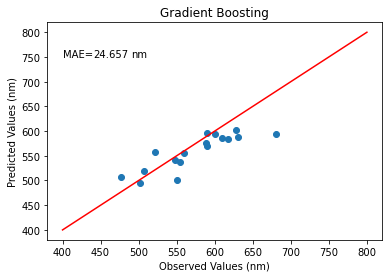

In [39]:
GB_regr = GradientBoostingRegressor(n_estimators=236, min_samples_split=19, min_samples_leaf=5, max_depth=6, random_state=54)
            
GB_regr.fit(X_train, np.ravel(Y_train))
GB_Y_pred = GB_regr.predict(X_test)
            
GB_mae = mean_absolute_error(Y_test, GB_Y_pred)
print("Mean absolute error =", round(GB_mae,3), 'nm')

plt.figure()
plt.title("Gradient Boosting")
plt.plot(Y_test, GB_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(GB_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Others

### Linear Regression

Mean absolute error = 256.316 nm


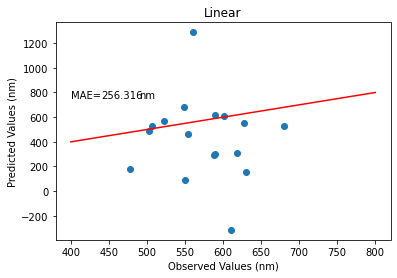

In [21]:
#using random search parameters
Linear_regr = LinearRegression()
Linear_regr.fit(X_train, np.ravel(Y_train))
            
Linear_Y_pred = Linear_regr.predict(X_test)
            
Linear_mae = mean_absolute_error(Y_test, Linear_Y_pred)
print("Mean absolute error =", round(Linear_mae,3), 'nm')

plt.figure()
plt.title("Linear")
plt.plot(Y_test, Linear_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Linear_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Lasso

In [22]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_lasso = RandomizedSearchCV(Lasso(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_lasso.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_lasso.best_score_)
print('Best Parameters : ',rs_lasso.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -40.839
Best Parameters :  {'selection': 'random', 'max_iter': 7580}
CPU times: user 3.34 s, sys: 91.4 ms, total: 3.43 s
Wall time: 11.1 s


Mean absolute error = 39.188 nm


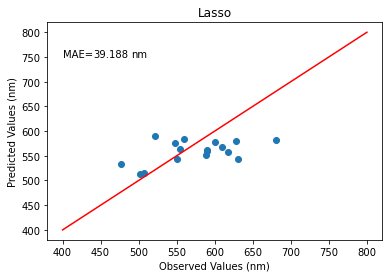

In [25]:
#using random search parameters
Lasso_regr = Lasso(selection='random', max_iter=7580)
Lasso_regr.fit(X_train, np.ravel(Y_train))
            
Lasso_Y_pred = Lasso_regr.predict(X_test)
            
Lasso_mae = mean_absolute_error(Y_test, Lasso_Y_pred)
print("Mean absolute error =", round(Lasso_mae,3), 'nm')

plt.figure()
plt.title("Lasso")
plt.plot(Y_test, Lasso_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Lasso_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### ElasticNet

In [26]:
%%time

#sklearn random search over n iterations

params = {'max_iter': range(1000,10001),
         'selection': ['cyclic', 'random']}

#n_jobs runs jobs in parallel, verbose prints updates
rs_en = RandomizedSearchCV(ElasticNet(), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_en.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_en.best_score_)
print('Best Parameters : ',rs_en.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -45.710
Best Parameters :  {'selection': 'random', 'max_iter': 1461}
CPU times: user 2.92 s, sys: 140 ms, total: 3.06 s
Wall time: 9.6 s


Mean absolute error = 43.893 nm


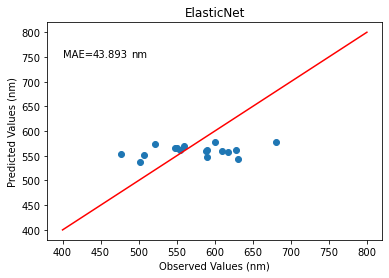

In [29]:
#using random search parameters
EN_regr = ElasticNet(selection='random', max_iter=1461)
EN_regr.fit(X_train, np.ravel(Y_train))
            
EN_Y_pred = EN_regr.predict(X_test)
            
EN_mae = mean_absolute_error(Y_test, EN_Y_pred)
print("Mean absolute error =", round(EN_mae,3), 'nm')

plt.figure()
plt.title("ElasticNet")
plt.plot(Y_test, EN_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(EN_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### Ridge

In [30]:
%%time

#sklearn random search over n iterations

params = {'max_iter':range(1000,10001),
         'random_state':range(1,1001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_ridge = RandomizedSearchCV(Ridge(solver='saga'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_ridge.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_ridge.best_score_)
print('Best Parameters : ',rs_ridge.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -39.056
Best Parameters :  {'random_state': 344, 'max_iter': 7586}
CPU times: user 2.94 s, sys: 62.8 ms, total: 3 s
Wall time: 23.8 s


Mean absolute error = 43.854 nm


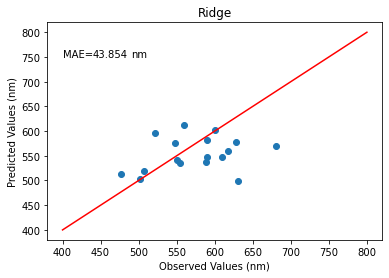

In [32]:
#using random search parameters
Ridge_regr = Ridge(max_iter=7586, random_state=344)
Ridge_regr.fit(X_train, np.ravel(Y_train))
            
Ridge_Y_pred = Ridge_regr.predict(X_test)
            
Ridge_mae = mean_absolute_error(Y_test, Ridge_Y_pred)
print("Mean absolute error =", round(Ridge_mae,3), 'nm')

plt.figure()
plt.title("Ridge")
plt.plot(Y_test, Ridge_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(Ridge_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='linear'

In [33]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrlin = RandomizedSearchCV(SVR(kernel='linear'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrlin.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrlin.best_score_)
print('Best Parameters : ',rs_svrlin.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -48.657
Best Parameters :  {'degree': 1, 'cache_size': 1026}
CPU times: user 2.36 s, sys: 113 ms, total: 2.48 s
Wall time: 7.89 s


Mean absolute error = 44.78 nm


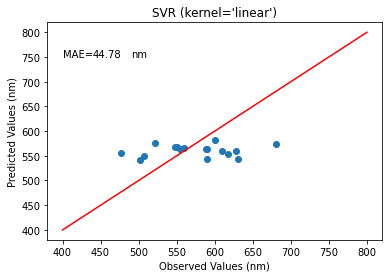

In [35]:
#using random search parameters
SVRlin_regr = SVR(kernel='linear', degree=1, cache_size=1026)
SVRlin_regr.fit(X_train, np.ravel(Y_train))
            
SVRlin_Y_pred = SVRlin_regr.predict(X_test)
            
SVRlin_mae = mean_absolute_error(Y_test, SVRlin_Y_pred)
print("Mean absolute error =", round(SVRlin_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='linear')")
plt.plot(Y_test, SVRlin_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRlin_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

### SVR kernel='rbf'

In [36]:
%%time

#sklearn random search over n iterations

params = {'degree':range(1,10),
         'cache_size':range(200,2001)}

#n_jobs runs jobs in parallel, verbose prints updates
rs_svrrbf = RandomizedSearchCV(SVR(kernel='rbf'), param_distributions=params, n_iter=1000, n_jobs=-1, verbose=10,
                           scoring='neg_mean_absolute_error')
rs_svrrbf.fit(X, np.ravel(Y))

print('Best MAE Score Through Random Search : %.3f'%rs_svrrbf.best_score_)
print('Best Parameters : ',rs_svrrbf.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best MAE Score Through Random Search : -50.939
Best Parameters :  {'degree': 1, 'cache_size': 1319}
CPU times: user 2.65 s, sys: 117 ms, total: 2.76 s
Wall time: 9.18 s


Mean absolute error = 43.731 nm


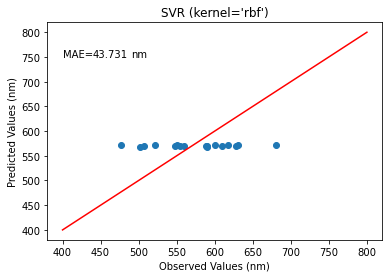

In [37]:
#using random search parameters
SVRrbf_regr = SVR(kernel='rbf', degree=1, cache_size=1319)
SVRrbf_regr.fit(X_train, np.ravel(Y_train))
            
SVRrbf_Y_pred = SVRrbf_regr.predict(X_test)
            
SVRrbf_mae = mean_absolute_error(Y_test, SVRrbf_Y_pred)
print("Mean absolute error =", round(SVRrbf_mae,3), 'nm')

plt.figure()
plt.title("SVR (kernel='rbf')")
plt.plot(Y_test, SVRrbf_Y_pred, 'o')
plt.xlabel('Observed Values (nm)')
plt.ylabel('Predicted Values (nm)')
plt.plot([400,800],[400,800], color = 'r')
plt.text(400, 750, 'MAE=' , fontdict=None)
plt.text(440, 750, round(SVRrbf_mae,3), fontdict=None)
plt.text(490, 750, 'nm', fontdict=None)
plt.show()

## Conclusion

Ridge gave the best performance, **solver='saga', max_iter=9513, random_state=918**

## Saving model

In [ ]:
Ridge_regr = Ridge(solver='saga', max_iter=9513, random_state=918)

Ridge_regr.fit(X_train, np.ravel(Y_train))
Ridge_Y_pred = Ridge_regr.predict(X_test)

joblib.dump(Ridge_regr, "./model_aug_em_Ridge.joblib")